In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.common.utils.image import load_image
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV
from torchlake.object_detection.models.yolov1 import YOLOV1Modified, YOLOLoss
from torchlake.common.utils.platform import get_num_workers, get_file_size
from torchlake.object_detection.utils.plot import draw_pred
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer

In [2]:
# import time
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random
from pathlib import Path

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov1')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = 2

In [6]:
CONTEXT = DetectorContext(
    detector_name="yolov1",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
)

# data

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 448

In [9]:
transform = A.Compose(
    [
        # A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.augmentations.geometric.resize.SmallestMaxSize(input_size),
        # A.RandomSizedBBoxSafeCrop(input_size, input_size),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [10]:
train_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_trainval.csv"),
    transform=transform,
)

In [11]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 448, 448]) 1


In [12]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [13]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([32, 3, 448, 448]) 32


# model

In [14]:
backbone = ResNetFeatureExtractor("resnet18", "block", trainable=True)
backbone.fix_target_layers(["4_1"])

In [15]:
model = YOLOV1Modified(backbone, CONTEXT).to(CONTEXT.device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV1Modified                                     --
├─ResNetFeatureExtractor: 1-1                      --
│    └─Sequential: 2-1                             --
│    │    └─Sequential: 3-1                        9,536
│    │    └─Sequential: 3-2                        147,968
│    │    └─Sequential: 3-3                        525,568
│    │    └─Sequential: 3-4                        2,099,712
│    │    └─Sequential: 3-5                        8,393,728
│    │    └─AdaptiveAvgPool2d: 3-6                 --
│    └─ImageNetNormalization: 2-2                  --
├─Sequential: 1-2                                  --
│    └─Conv2dNormActivation: 2-3                   --
│    │    └─Conv2d: 3-7                            4,718,592
│    │    └─BatchNorm2d: 3-8                       2,048
│    │    └─LeakyReLU: 3-9                         --
│    └─Conv2dNormActivation: 2-4                   --
│    │    └─Conv2d: 3-10                

# train

In [17]:
EPOCH = 10

In [18]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = YOLOLoss(CONTEXT, lambda_coord=5, lambda_noobject=0.5)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [ ]:
# TODO: weight decay, longer epoch, iou loss, resnet34
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

100%|██████████| 517/517 [10:24<00:00,  1.21s/it]


epoch 1 : 0.0003199792935758851


100%|██████████| 517/517 [03:59<00:00,  2.16it/s]


epoch 2 : 0.0002396661754505262


100%|██████████| 517/517 [03:59<00:00,  2.15it/s]


epoch 3 : 0.00022963584336876415


100%|██████████| 517/517 [04:02<00:00,  2.13it/s]


epoch 4 : 0.0002253908289691462


100%|██████████| 517/517 [04:00<00:00,  2.15it/s]


epoch 5 : 0.00022121462086598413


100%|██████████| 517/517 [04:02<00:00,  2.13it/s]


epoch 6 : 0.00021856594970922673


100%|██████████| 517/517 [04:07<00:00,  2.09it/s]


epoch 7 : 0.0002151085584250151


100%|██████████| 517/517 [04:06<00:00,  2.10it/s]


epoch 8 : 0.00020713517223926156


100%|██████████| 517/517 [04:23<00:00,  1.97it/s]


epoch 9 : 0.00020294606171001643


100%|██████████| 517/517 [04:01<00:00,  2.14it/s]

epoch 10 : 0.00020127372121653652


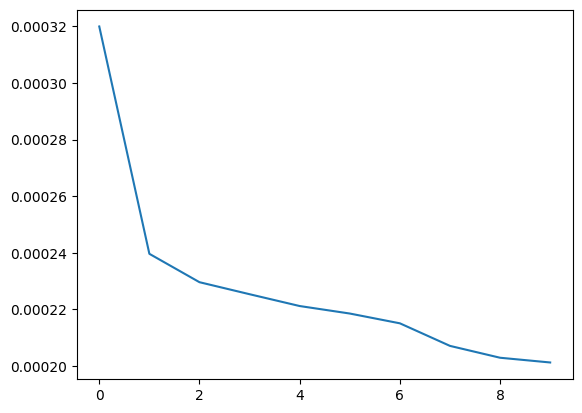

In [22]:
plt.plot(training_loss)

In [18]:
model_path = artifact_path / f'yolov1.{backbone.network_name}.pth'

In [53]:
torch.save(model.state_dict(), model_path)

In [25]:
get_file_size(model_path)

'169.84MiB'

In [19]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>

# Inference

In [27]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.yolo_predictor import YOLOPredictor

In [28]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [29]:
predictor = YOLOPredictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [30]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [31]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [32]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [33]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [34]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [35]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B, C+1, H, W
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/154 [00:00<?, ?it/s]


In [36]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

car: 0.43
car: 0.31
car: 0.15
car: 0.48
person: 0.17
person: 0.19
car: 0.46
person: 0.33
person: 0.13
person: 0.37
person: 0.28
cat: 0.13
tvmonitor: 0.33
dog: 0.19
horse: 0.13
person: 0.22
bottle: 0.16
person: 0.18
person: 0.11
cat: 0.18
car: 0.12
car: 0.27
car: 0.16
person: 0.23
person: 0.32
horse: 0.19
person: 0.27
car: 0.56
person: 0.24
person: 0.43
person: 0.34
dog: 0.22
car: 0.28
motorbike: 0.22
bird: 0.10
bird: 0.24
bird: 0.11
person: 0.20
bottle: 0.15
bottle: 0.13
person: 0.21
person: 0.19
person: 0.38
person: 0.39
bicycle: 0.19
bird: 0.14
bus: 0.20
bus: 0.13
bus: 0.12
boat: 0.13
boat: 0.13
boat: 0.17


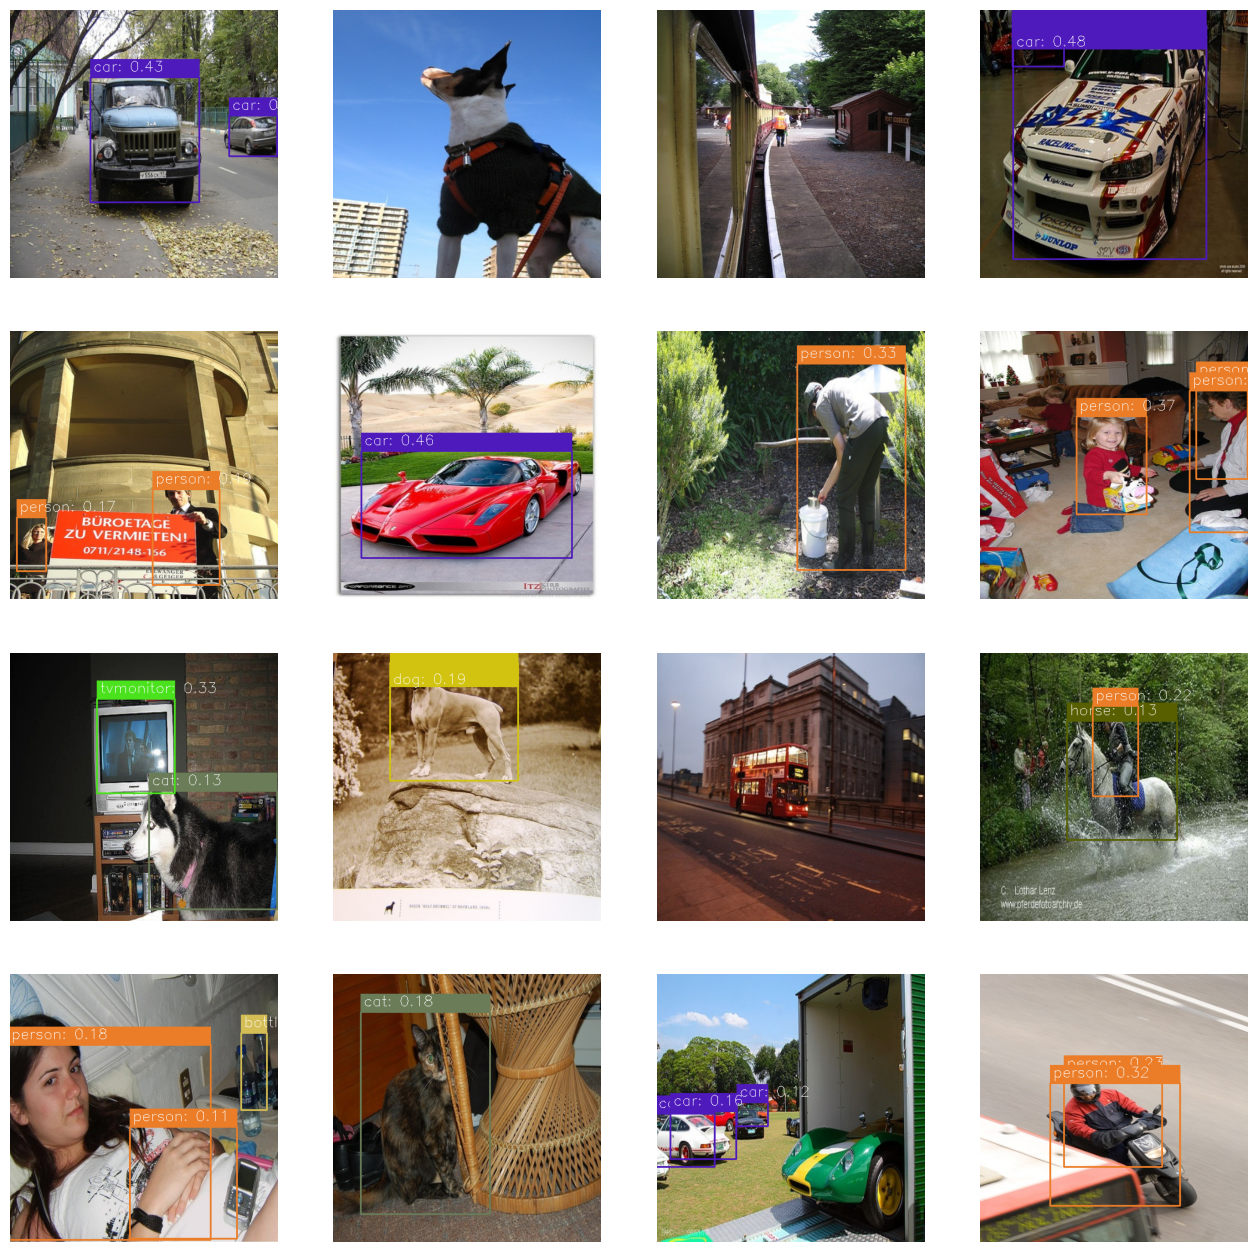

In [37]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [ ]:
humans_img = "24399.jpg"
human_img = "20240612_091521.jpg"
obj_img = "data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.41
person: 0.50
D://W/gf/1672998424399.jpg 2
person: 0.24
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.39
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 1


In [25]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 0.25
person: 0.23
person: 0.24
person: 0.22
person: 0.25
person: 0.24
person: 0.22
person: 0.20
person: 0.23
person: 0.21
person: 0.26
person: 0.25
person: 0.22
person: 0.23
person: 0.27
person: 0.30
person: 0.29
person: 0.29
person: 0.10
person: 0.15
person: 0.15
person: 0.19
person: 0.18
person: 0.23
person: 0.24
person: 0.16
person: 0.11
person: 0.11
person: 0.12
person: 0.11
person: 0.13
person: 0.10
person: 0.12
person: 0.12
person: 0.11
person: 0.22
person: 0.21
person: 0.20
person: 0.18
person: 0.20
person: 0.24
person: 0.26
person: 0.27
person: 0.27
person: 0.26
person: 0.24
person: 0.27
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.22
person: 0.21
person: 0.21
person: 0.20
person: 0.21
person: 0.20
person: 0.19
person: 0.19
person: 0.21
person: 0.22
person: 0.22
person: 0.25
person: 0.28
person: 0.27
person: 0.31
person: 0.30
person: 0.30
person: 0.28
person: 0.29
person: 0.30
person: 0.29
person: 0.27
person: 0.28
person: 0.28
person: 0.29

# evaluation

In [38]:
from torchlake.object_detection.models.yolov1.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg
from torchlake.object_detection.controller.yolo_predictor import YOLOPredictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [39]:
decoder = Decoder(CONTEXT)
inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.1, NMS_THRESH=0.5)

In [40]:
predictor = YOLOPredictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [41]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ]
)

In [43]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [44]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [ ]:
evaluator = Evaluator(CONTEXT)

In [47]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [01:16<00:00,  2.01it/s]

       aeroplane   bicycle      bird      boat    bottle       bus       car  \
AP@0.5  0.533938  0.525881  0.507927  0.498499  0.406704  0.409273  0.498645   

             cat    chair       cow  ...     dog    horse motorbike    person  \
AP@0.5  0.504722  0.42333  0.419197  ...  0.4285  0.49719  0.496614  0.495888   

       pottedplant     sheep      sofa     train tvmonitor  all  
AP@0.5    0.490786  0.488356  0.487587  0.489821   0.49014  NaN  

[1 rows x 21 columns]


In [54]:
result_table.T

AP@0.5
aeroplane    0.533938
bicycle      0.525881
bird         0.507927
boat         0.498499
bottle       0.406704
bus          0.409273
car          0.498645
cat          0.504722
chair         0.42333
cow          0.419197
diningtable   0.42384
dog            0.4285
horse         0.49719
motorbike    0.496614
person       0.495888
pottedplant  0.490786
sheep        0.488356
sofa         0.487587
train        0.489821
tvmonitor     0.49014
all          0.475842

In [ ]:
for path in artifact_path.joinpath(evaluator.cfg.MODEL.BACKBONE).glob("*.pth"):
    model.load_state_dict(torch.load(path))

    evaluator.run(
        predictor,
        model,
        test_loader,
        VOC_CLASS_NAMES,
        save_dir=artifact_path.as_posix(),
        output_filename=f"{path.stem}.eval.csv",
    )

bird: 0.37
person: 0.34
person: 0.31
person: 0.53
dog: 0.31
motorbike: 0.72
motorbike: 0.86
dog: 0.69
dog: 0.71
person: 0.31
person: 0.40


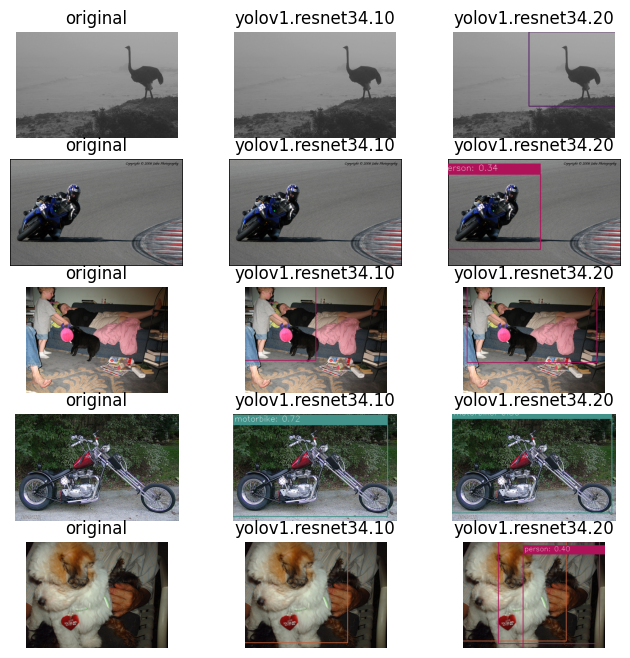

In [11]:
transform = predictor.prepare_inference()

image_paths = glob('D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/*')
random_selected_image_paths = random.choices(image_paths, k=5)

weight_paths = list(map(str, artifact_path.joinpath(predictor.cfg.MODEL.BACKBONE).glob('*.pth')))

titles = []
predictions = []
for image_path in random_selected_image_paths:
    img = load_image(image_path, is_numpy=True)
    predictions.append(img)
    titles.append('original')
    for weight_path in weight_paths:
        copied_img = img.copy()
        
        predictor.load_weight(weight_path)
        prediction = predictor.detect_single_image(img, transform)
        draw_pred(copied_img, prediction, predictor.class_names, class_color=predictor.palette)
        predictions.append(copied_img)
        titles.append(Path(weight_path).stem)

plot_grids(predictions, titles, 5, 1+len(weight_paths))

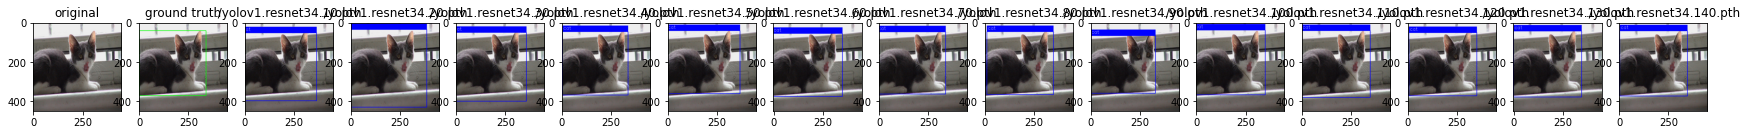

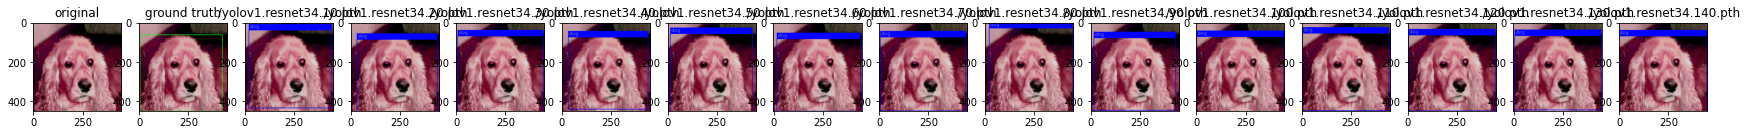

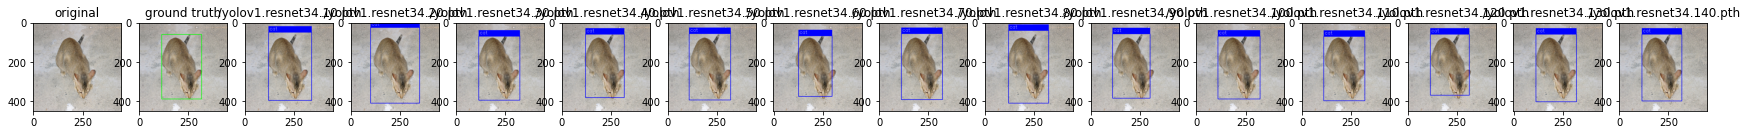

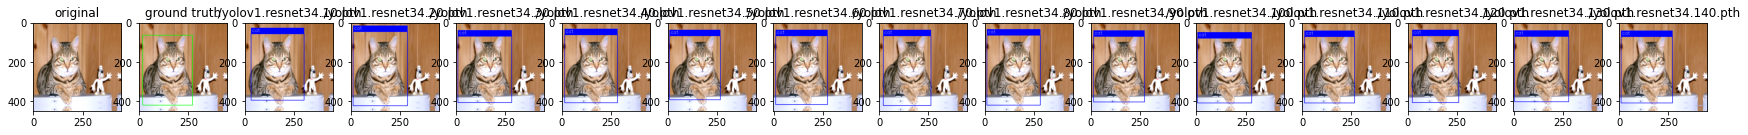

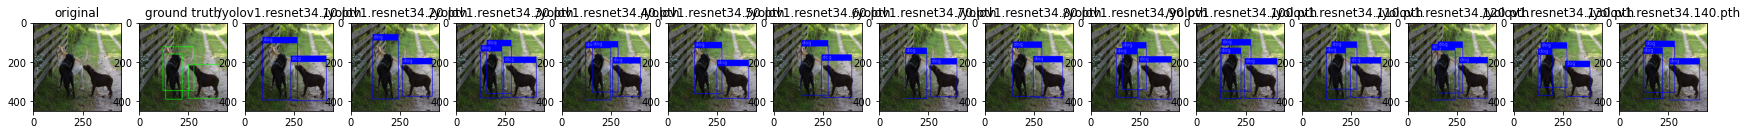

In [34]:
lots_of_prediction_and_lots_of_model(np.random.randint(low=0,high=len(trainset),size=5),
                                     )

# all epoch evaluation

In [ ]:
result_table = pd.concat([pd.read_csv(eval_file) for eval_file in artifact_path.glob('*eval.csv')], ignore_index=True)

In [25]:
result_table

Unnamed: 0  aeroplane   bicycle  \
0  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.285928  0.243080   
1  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.334452  0.264394   
2  ..\..\artifacts\yolov1\resnet34\yolov1.resnet3...   0.343156  0.264758   

       bird      boat    bottle       bus       car       cat     chair  ...  \
0  0.151106  0.151515  0.090909  0.322694  0.268679  0.421576  0.090909  ...   
1  0.235090  0.160079  0.090909  0.432416  0.271636  0.519197  0.090909  ...   
2  0.237434  0.211670  0.090909  0.425696  0.271030  0.531502  0.090909  ...   

        dog     horse  motorbike    person  pottedplant     sheep      sofa  \
0  0.264929  0.304034   0.250271  0.141176     0.090909  0.090909  0.238564   
1  0.406530  0.402499   0.334981  0.166877     0.090909  0.163636  0.303895   
2  0.423003  0.411214   0.302629  0.171145     0.090909  0.174825  0.285663   

      train  tvmonitor       all  
0  0.327961   0.090909  0.214908  
1  0.414163   0.132353  0.264781  
2  0.403578   0.131752  0.273925  

[3 rows x 22 columns]

<AxesSubplot:>

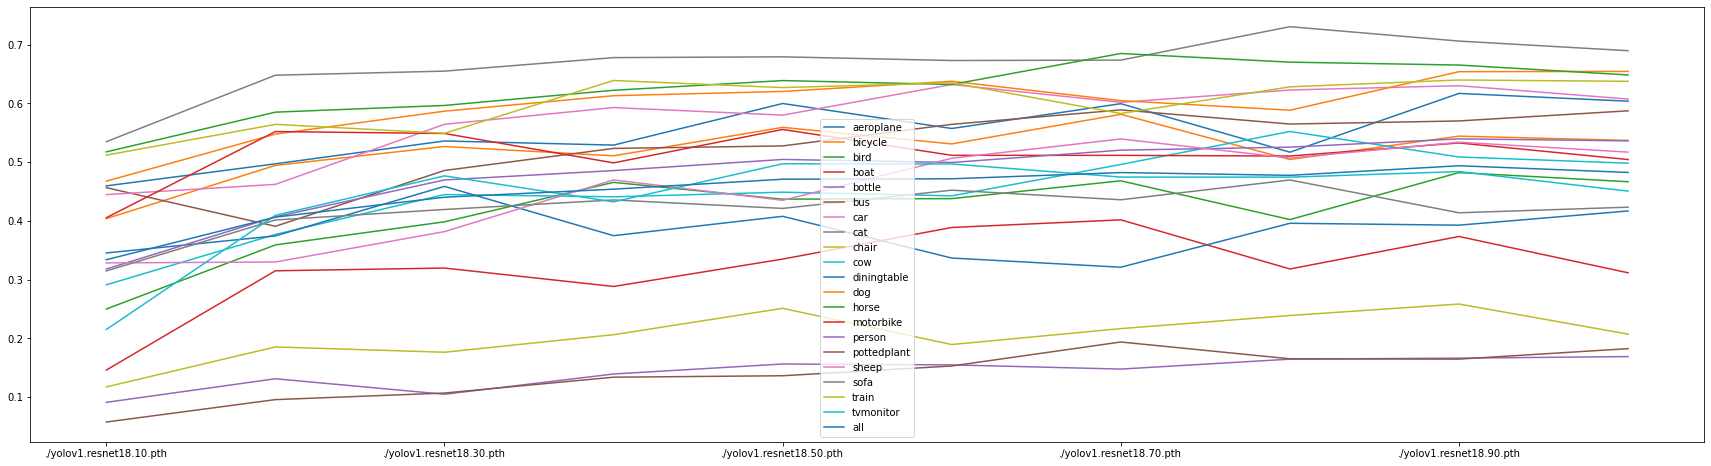

In [47]:
result_table.plot(figsize=(30,8))

<AxesSubplot:title={'center':'validation mAP on VOC 2007 test set'}>

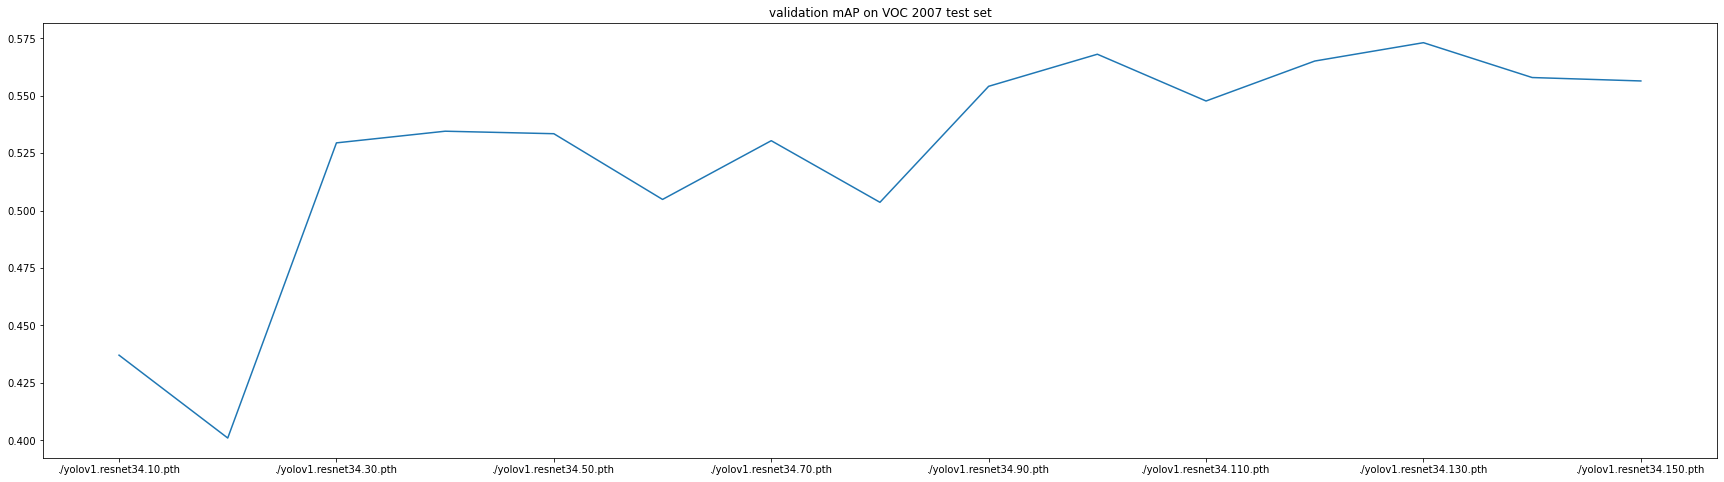

In [42]:
result_table['all'].plot(figsize=(30,8),title="validation mAP on VOC 2007 test set")

# debug

In [55]:
AP, _ = evaluator.evaluate_detector(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 154/154 [01:17<00:00,  1.98it/s]


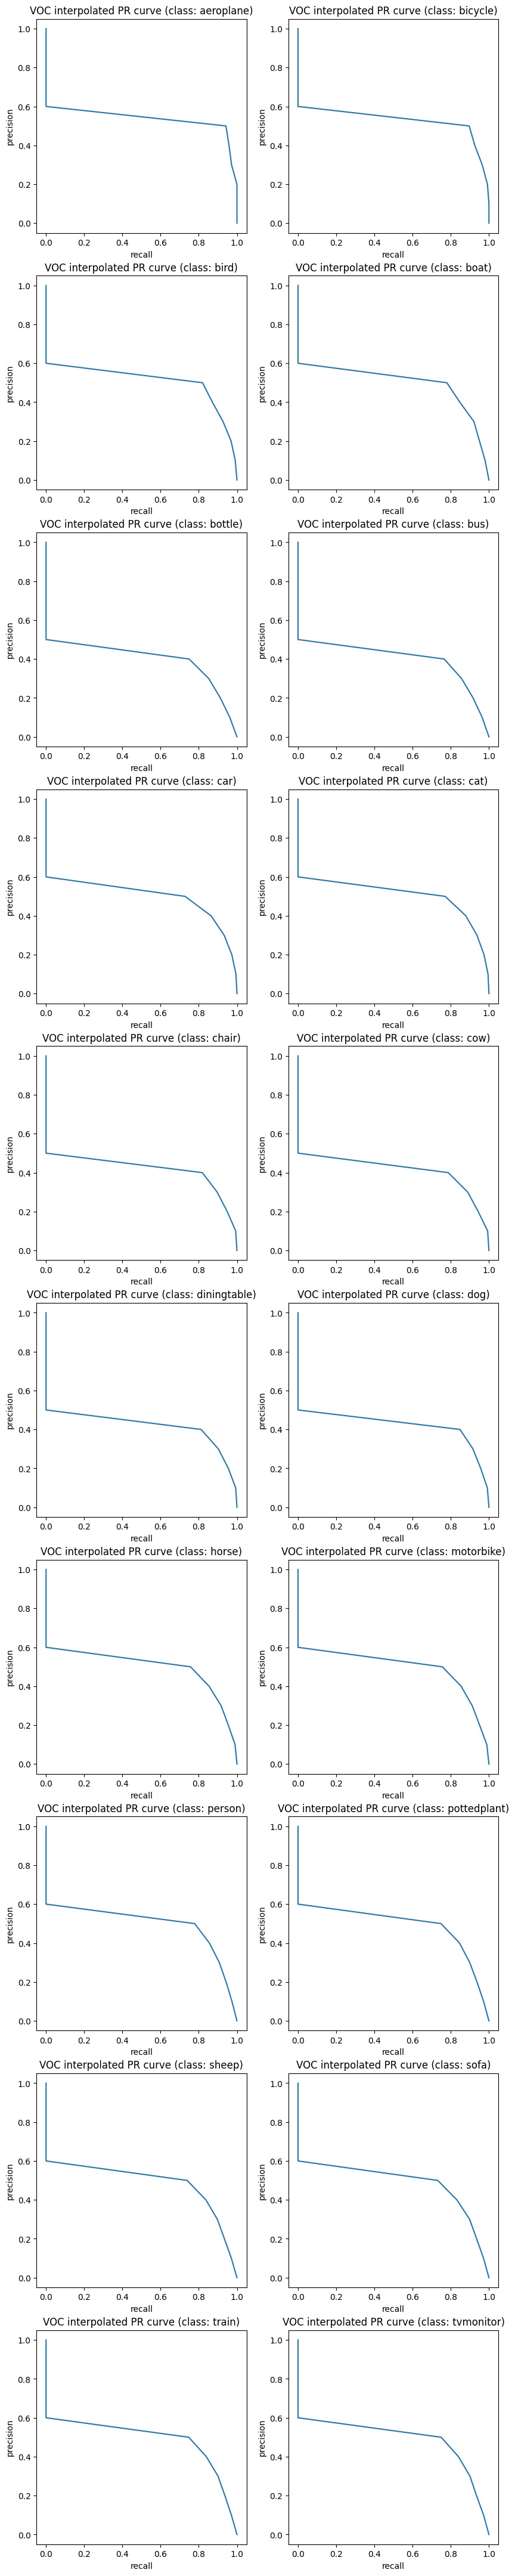

In [70]:
plt.figure(figsize=(10, 55))
for c_idx, class_name in enumerate(VOC_CLASS_NAMES):
    plt.subplot(len(VOC_CLASS_NAMES) // 2, 2, c_idx+1)
    plt.plot(AP[class_name][0], AP[class_name][1])
    plt.title(f"VOC interpolated PR curve (class: {class_name})")
    plt.xlabel("recall")
    plt.ylabel("precision")

In [43]:
interest_cls = 'aeroplane'
Iamnotsure = pd.DataFrame({
    'iou': torch.cat([a for a, b, c in debug_map[interest_cls] if a is not None],0).numpy(),
    'prob': torch.cat([b for a, b, c in debug_map[interest_cls] if b is not None],0).numpy(),
    'gt': sum(c for a, b, c in debug_map[interest_cls])
}).sort_values('prob',ascending=False)
Iamnotsure['TP'] = Iamnotsure['iou'].gt(0.5).cumsum()
Iamnotsure['precision'] = Iamnotsure['TP']/np.arange(1,len(Iamnotsure)+1)
Iamnotsure['recall'] = Iamnotsure['TP']/Iamnotsure['gt']
Iamnotsure

iou      prob     gt   TP  precision    recall
71   0.884566  0.890917  265.0    1   1.000000  0.003774
100  0.955297  0.890582  265.0    2   1.000000  0.007547
142  0.851079  0.879476  265.0    3   1.000000  0.011321
134  0.940841  0.871596  265.0    4   1.000000  0.015094
200  0.811990  0.857263  265.0    5   1.000000  0.018868
..        ...       ...    ...  ...        ...       ...
101  0.518033  0.335952  265.0  190   0.867580  0.716981
58   0.000000  0.321791  265.0  190   0.863636  0.716981
164  0.577316  0.320824  265.0  191   0.864253  0.720755
28   0.000000  0.319813  265.0  191   0.860360  0.720755
13   0.655200  0.318804  265.0  192   0.860987  0.724528

[223 rows x 6 columns]

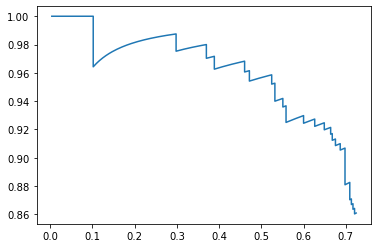

In [44]:
# plt.ylim(0,1.3)
plt.plot(Iamnotsure['recall'], Iamnotsure['precision'])

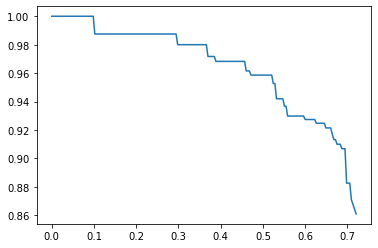

In [45]:
a,b = all_pr_curve(eval_table[interest_cls]['precision'],eval_table[interest_cls]['recall'])
plt.plot(b, a)

In [11]:
r18 = pd.read_csv('Final.1e-4/eval.csv',index_col=0)
r34 = pd.read_csv('Final.1e-4.34/eval.csv',index_col=0)

In [14]:
pd.concat([r18,r34]).loc[['./yolov1.resnet18.150.pth','./yolov1.resnet34.130.pth']].transpose()

./yolov1.resnet18.150.pth  ./yolov1.resnet34.130.pth
aeroplane                     0.659695                   0.699073
bicycle                       0.601857                   0.635265
bird                          0.528688                   0.610817
boat                          0.457822                   0.517191
bottle                        0.199932                   0.248924
bus                           0.630690                   0.716136
car                           0.658628                   0.670062
cat                           0.751293                   0.761671
chair                         0.216588                   0.309187
cow                           0.550103                   0.604650
diningtable                   0.491263                   0.451624
dog                           0.642533                   0.665584
horse                         0.673473                   0.693687
motorbike                     0.577631                   0.619246
person                        0.557463                   0.591511
pottedplant                   0.188593                   0.247500
sheep                         0.479674                   0.601104
sofa                          0.458513                   0.494099
train                         0.693138                   0.739554
tvmonitor                     0.460606                   0.585502
all                           0.523909                   0.573119

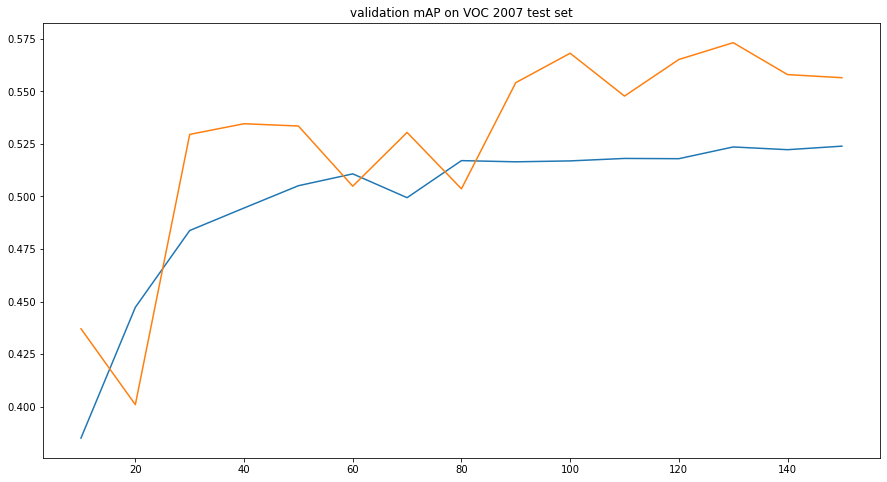

In [23]:
plt.figure(figsize=(15,8))
plt.title("validation mAP on VOC 2007 test set")
plt.plot(range(10,160,10), r18['all'])
plt.plot(range(10,160,10), r34['all'])